IQP Entanglement Witness — Short Description
The Circuit
IQP = H⊗n → CZ(edges) → H⊗n
Linear chain of 15 qubits with CZ gates between neighbors.

The Method
Step 1: Define Stabilizers
For IQP state, each qubit i has a stabilizer:
S_i = Z_i × ∏(X_j for all neighbors j)
Example for linear chain:

S₀ = Z₀ × X₁
S₁ = Z₁ × X₀ × X₂
S₂ = Z₂ × X₁ × X₃
...

Step 2: Measure Each Stabilizer
For each S_i:

Prepare IQP state (H-CZ-H)
Add H gates on neighbor qubits (to measure X)
Measure all qubits
Compute: s = z_i × x_j × x_k × ...
Average over all shots → ⟨S_i⟩

Step 3: Evaluate Entanglement
If avg(⟨S_i⟩) > 0.5 → ENTANGLED
If avg(⟨S_i⟩) ≤ 0.5 → Not conclusively entangled

Why It Works
State Typeavg⟨S⟩ReasonIdeal IQP+1.0Stabilizer definition: S|ψ⟩ = +1|ψ⟩Separable≈ 0Factorizes: ⟨Z⟩⟨X⟩⟨X⟩ → random signs cancelNoisy IQP0.5–1.0Reduced but still shows entanglement
Key point: Separable states cannot have avg⟨S⟩ > 0.5 for this stabilizer structure.

Results
Testavg⟨S⟩VerdictIdeal simulator1.000✅ PerfectRandom product state-0.025❌ Not entangled (correct!)IQM Emerald (15 qubits)0.555✅ ENTANGLED
Fidelity estimate: F = (1 + 0.555)/2 = 77.8%

Conclusion
15-qubit IQP entanglement PROVEN on IQM Emerald
avg⟨S⟩ = 0.555 > 0.5 threshold

In [1]:
# CELL 1: Setup
import sys
import subprocess

major, minor = sys.version_info[:2]
if not (major == 3 and minor >= 11):
    print(f"❌ Python {major}.{minor} - need 3.11+")
    raise SystemExit
print(f"✅ Python {major}.{minor} OK")

pip_ver = subprocess.check_output(["pip", "--version"]).decode().split()[1]
if not pip_ver.startswith("25"):
    !pip install --upgrade pip==25.*
    print("✅ pip 25 installed. RESTART runtime!")
else:
    print("✅ pip OK")

✅ Python 3.12 OK
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
✅ pip 25 installed. RESTART runtime!


In [1]:
# install iqm-client with qrisp extras
!pip install -U "iqm-client>=33.0.1" "qrisp[iqm]"
# used for visualization
!pip install matplotlib

from qrisp.interface import IQMBackend

# ============================================
# CONFIGURATION - CHANGE THESE AS NEEDED
# ============================================
API_TOKEN = "/LEwLyRbOmGG6L0qQWp1vgF0tKyWEJcVrD75tS+loWoBnBU9P+N/A75B/jzVJglB"
DEVICE = "emerald"  # Changed from sirius to garnet to emerald!

quantum_computer = IQMBackend(
    api_token = API_TOKEN,
    device_instance = DEVICE
)

print(f"✅ Connected to IQM {DEVICE.upper()}!")

✅ Connected to IQM EMERALD!


In [2]:
from iqm.qiskit_iqm import IQMProvider

provider = IQMProvider("https://resonance.meetiqm.com",
                       quantum_computer="emerald",
                       token="/LEwLyRbOmGG6L0qQWp1vgF0tKyWEJcVrD75tS+loWoBnBU9P+N/A75B/jzVJglB")
backend = provider.get_backend()

In [3]:
from qiskit import QuantumCircuit, transpile
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
from collections import deque

In [4]:
from dataclasses import dataclass
from itertools import combinations

In [5]:
from typing import List, Dict, Tuple

In [6]:
from qiskit.quantum_info import Statevector

In [7]:
from dataclasses import dataclass, field

In [15]:
from qiskit_aer import AerSimulator

In [9]:
# CELL 3: Create IQP circuit (H-CZ-H)

def create_iqp(n_qubits: int, edges: List[Tuple[int, int]]) -> QuantumCircuit:
    """
    Create IQP circuit: H - CZ - H
    """
    qc = QuantumCircuit(n_qubits)

    # H layer
    for i in range(n_qubits):
        qc.h(i)

    # CZ layer
    for i, j in edges:
        qc.cz(i, j)

    # Final H layer
    for i in range(n_qubits):
        qc.h(i)

    return qc

print("✅ IQP circuit creator ready")

✅ IQP circuit creator ready


In [10]:
# CELL 4: Get neighbors in graph

def get_neighbors(qubit: int, edges: List[Tuple[int, int]]) -> List[int]:
    """Get neighbors of a qubit in the graph."""
    neighbors = []
    for i, j in edges:
        if i == qubit:
            neighbors.append(j)
        elif j == qubit:
            neighbors.append(i)
    return sorted(neighbors)

print("✅ Neighbor function ready")

✅ Neighbor function ready


In [11]:
# CELL 5: Create IQP stabilizer measurement circuit

def create_iqp_stabilizer_circuit(n_qubits: int, edges: List[Tuple[int, int]],
                                   target_qubit: int) -> QuantumCircuit:
    """
    Create circuit to measure IQP stabilizer:

    S_i = Z_i × ∏_{j ∈ neighbors} X_j

    Measurement strategy:
    - Target qubit i: measure in Z basis (no change)
    - Neighbor qubits j: measure in X basis (add H before measurement)
    - Other qubits: measure in Z basis (default)
    """
    # First create IQP state
    qc = create_iqp(n_qubits, edges)

    # Get neighbors of target
    neighbors = get_neighbors(target_qubit, edges)

    # Add H to neighbors for X-basis measurement
    for nb in neighbors:
        qc.h(nb)

    # Target qubit stays in Z basis (no H)
    # Other qubits also Z basis

    qc.measure_all()
    return qc, neighbors

print("✅ IQP stabilizer circuit creator ready")

✅ IQP stabilizer circuit creator ready


In [12]:
# CELL 6: Calculate stabilizer expectation from counts

def calc_iqp_stabilizer(counts: Dict[str, int], target: int,
                        neighbors: List[int], n_qubits: int) -> float:
    """
    Calculate ⟨S_i⟩ = ⟨Z_i × ∏_j X_j⟩ from measurement counts.

    The circuit already has:
    - Target measured in Z basis → gives z_i ∈ {+1, -1}
    - Neighbors measured in X basis (via H) → gives x_j ∈ {+1, -1}

    S_i = z_i × ∏_j x_j
    """
    total = sum(counts.values())
    expectation = 0.0

    for bitstring, count in counts.items():
        # Get Z eigenvalue for target qubit
        bit_target = int(bitstring[-(target + 1)])
        z_i = 1 - 2 * bit_target  # |0⟩ → +1, |1⟩ → -1

        # Get X eigenvalues for neighbors (already measured in X basis)
        x_product = 1
        for nb in neighbors:
            bit_nb = int(bitstring[-(nb + 1)])
            x_j = 1 - 2 * bit_nb
            x_product *= x_j

        # Stabilizer value
        s_i = z_i * x_product
        expectation += s_i * count / total

    return expectation

print("✅ Stabilizer calculator ready")

✅ Stabilizer calculator ready


In [13]:
# CELL 7: Complete IQP Entanglement Witness

class IQPEntanglementWitness:
    """
    🔐 Entanglement Witness for IQP (H-CZ-H) circuits.

    Uses IQP stabilizers: S_i = Z_i × ∏_{j ∈ neighbors} X_j

    For ideal IQP state: ⟨S_i⟩ = +1 for all i
    For separable state: ⟨S_i⟩ can be < 1

    If avg(⟨S_i⟩) > 0.5 → ENTANGLEMENT PROVEN!
    """

    def __init__(self, n_qubits: int, edges: List[Tuple[int, int]]):
        self.n_qubits = n_qubits
        self.edges = edges

        # Build neighbor map
        self.neighbors = {}
        for i in range(n_qubits):
            self.neighbors[i] = get_neighbors(i, edges)

    def run_test(self, backend, path: List[int], shots: int = 4000) -> Dict:
        """
        Run complete IQP entanglement test.

        Measures ⟨S_i⟩ for each qubit i.
        """
        print(f"\n{'='*60}")
        print(f"🔐 IQP ENTANGLEMENT WITNESS")
        print(f"   Circuit: H - CZ - H")
        print(f"   Qubits: {self.n_qubits}")
        print(f"   Edges: {self.edges}")
        print(f"{'='*60}")

        print(f"\n📐 IQP Stabilizers (S_i = Z_i × ∏ X_neighbors):")
        for i in range(self.n_qubits):
            nbs = self.neighbors[i]
            stab_str = f"Z_{i}"
            for nb in nbs:
                stab_str += f" × X_{nb}"
            print(f"   S_{i} = {stab_str}")

        stabilizer_values = []
        results_detail = []

        print(f"\n🔬 Measuring stabilizers...")
        for i in range(self.n_qubits):
            nbs = self.neighbors[i]

            # Create and run circuit
            qc, _ = create_iqp_stabilizer_circuit(self.n_qubits, self.edges, i)
            qc_t = transpile(qc, backend, initial_layout=path, optimization_level=3)

            job = backend.run(qc_t, shots=shots)
            counts = job.result().get_counts()

            # Calculate stabilizer
            s_i = calc_iqp_stabilizer(counts, i, nbs, self.n_qubits)
            stabilizer_values.append(s_i)

            status = '✅' if s_i > 0.5 else '⚠️' if s_i > 0 else '❌'
            print(f"   S_{i} = Z_{i}", end="")
            for nb in nbs:
                print(f"×X_{nb}", end="")
            print(f" → ⟨S_{i}⟩ = {s_i:+.4f} {status}")

            results_detail.append({
                'qubit': i,
                'neighbors': nbs,
                'stabilizer': s_i,
                'counts': counts,
            })

        # Summary statistics
        avg_stab = np.mean(stabilizer_values)
        min_stab = min(stabilizer_values)
        max_stab = max(stabilizer_values)
        sum_stab = sum(stabilizer_values)

        # Fidelity estimate: F ≈ (1 + avg⟨S⟩) / 2
        fidelity = (1 + avg_stab) / 2

        # Entanglement criterion
        is_entangled = avg_stab > 0.5

        return {
            'n_qubits': self.n_qubits,
            'edges': self.edges,
            'stabilizer_values': stabilizer_values,
            'avg_stabilizer': avg_stab,
            'min_stabilizer': min_stab,
            'max_stabilizer': max_stab,
            'sum_stabilizers': sum_stab,
            'fidelity': fidelity,
            'is_entangled': is_entangled,
            'results_detail': results_detail,
        }

print("✅ IQPEntanglementWitness class ready")

✅ IQPEntanglementWitness class ready


---
## 🧪 Test on Simulator First
---

In [25]:
# CELL 8: Test on IDEAL simulator

print("="*60)
print("TEST: IQP Stabilizer Witness on IDEAL Simulator")
print("="*60)

# Create 4-qubit linear IQP
N_TEST = 15
edges_test = [(i, i+1) for i in range(N_TEST - 1)]

# Show the IQP circuit
qc_iqp = create_iqp(N_TEST, edges_test)
print(f"\nIQP Circuit (H-CZ-H):")
print(qc_iqp.draw())

# Create witness
witness_test = IQPEntanglementWitness(N_TEST, edges_test)

# Run on ideal simulator
sim = AerSimulator()
path_test = list(range(N_TEST))

result_test = witness_test.run_test(sim, path_test, shots=10000)

print(f"\n{'='*60}")
print("RESULTS (IDEAL SIMULATOR):")
print(f"{'='*60}")
print(f"   Stabilizer values: {[f'{s:.4f}' for s in result_test['stabilizer_values']]}")
print(f"   Average ⟨S⟩: {result_test['avg_stabilizer']:.4f}")
print(f"   Fidelity estimate: {result_test['fidelity']:.4f}")
print(f"\n   🔗 ENTANGLED: {result_test['is_entangled']} {'✅' if result_test['is_entangled'] else '❌'}")

TEST: IQP Stabilizer Witness on IDEAL Simulator

IQP Circuit (H-CZ-H):
      ┌───┐   ┌───┐                                                            »
 q_0: ┤ H ├─■─┤ H ├────────────────────────────────────────────────────────────»
      ├───┤ │ └───┘┌───┐                                                       »
 q_1: ┤ H ├─■───■──┤ H ├───────────────────────────────────────────────────────»
      ├───┤     │  └───┘┌───┐                                                  »
 q_2: ┤ H ├─────■────■──┤ H ├──────────────────────────────────────────────────»
      ├───┤          │  └───┘┌───┐                                             »
 q_3: ┤ H ├──────────■────■──┤ H ├─────────────────────────────────────────────»
      ├───┤               │  └───┘┌───┐                                        »
 q_4: ┤ H ├───────────────■────■──┤ H ├────────────────────────────────────────»
      ├───┤                    │  └───┘┌───┐                                   »
 q_5: ┤ H ├────────────────────■────■─

In [26]:
# CELL 9: Test with NOISE

print("\n" + "="*60)
print("TEST: With DEPOLARIZING NOISE")
print("="*60)

from qiskit_aer.noise import NoiseModel, depolarizing_error

# Create noisy simulator
noise_model = NoiseModel()
error_1q = depolarizing_error(0.005, 1)  # 0.5% single-qubit
error_2q = depolarizing_error(0.02, 2)   # 2% two-qubit
noise_model.add_all_qubit_quantum_error(error_1q, ['h'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cz'])

noisy_sim = AerSimulator(noise_model=noise_model)

result_noisy = witness_test.run_test(noisy_sim, path_test, shots=10000)

print(f"\n{'='*60}")
print("RESULTS (WITH NOISE):")
print(f"{'='*60}")
print(f"   Stabilizer values: {[f'{s:.4f}' for s in result_noisy['stabilizer_values']]}")
print(f"   Average ⟨S⟩: {result_noisy['avg_stabilizer']:.4f}")
print(f"   Fidelity estimate: {result_noisy['fidelity']:.4f}")
print(f"\n   🔗 ENTANGLED: {result_noisy['is_entangled']} {'✅' if result_noisy['is_entangled'] else '❌'}")


TEST: With DEPOLARIZING NOISE

🔐 IQP ENTANGLEMENT WITNESS
   Circuit: H - CZ - H
   Qubits: 15
   Edges: [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14)]

📐 IQP Stabilizers (S_i = Z_i × ∏ X_neighbors):
   S_0 = Z_0 × X_1
   S_1 = Z_1 × X_0 × X_2
   S_2 = Z_2 × X_1 × X_3
   S_3 = Z_3 × X_2 × X_4
   S_4 = Z_4 × X_3 × X_5
   S_5 = Z_5 × X_4 × X_6
   S_6 = Z_6 × X_5 × X_7
   S_7 = Z_7 × X_6 × X_8
   S_8 = Z_8 × X_7 × X_9
   S_9 = Z_9 × X_8 × X_10
   S_10 = Z_10 × X_9 × X_11
   S_11 = Z_11 × X_10 × X_12
   S_12 = Z_12 × X_11 × X_13
   S_13 = Z_13 × X_12 × X_14
   S_14 = Z_14 × X_13

🔬 Measuring stabilizers...
   S_0 = Z_0×X_1 → ⟨S_0⟩ = +0.9456 ✅
   S_1 = Z_1×X_0×X_2 → ⟨S_1⟩ = +0.9310 ✅
   S_2 = Z_2×X_1×X_3 → ⟨S_2⟩ = +0.9326 ✅
   S_3 = Z_3×X_2×X_4 → ⟨S_3⟩ = +0.9270 ✅
   S_4 = Z_4×X_3×X_5 → ⟨S_4⟩ = +0.9350 ✅
   S_5 = Z_5×X_4×X_6 → ⟨S_5⟩ = +0.9318 ✅
   S_6 = Z_6×X_5×X_7 → ⟨S_6⟩ = +0.9358 ✅
   S_7 = Z_7×X_6×X_8 → ⟨S_7⟩ = 

In [28]:
# CELL 10: Test SEPARABLE state (H-H, no CZ)

print("\n" + "="*60)
print("TEST: SEPARABLE state (H-H, NO CZ gates)")
print("="*60)

# Create witness with NO EDGES (no CZ gates = separable!)
witness_sep = IQPEntanglementWitness(N_TEST, [])  # Empty edges!

result_sep = witness_sep.run_test(sim, path_test, shots=10000)

print(f"\n{'='*60}")
print("RESULTS (SEPARABLE - NO CZ):")
print(f"{'='*60}")
print(f"   Stabilizer values: {[f'{s:.4f}' for s in result_sep['stabilizer_values']]}")
print(f"   Average ⟨S⟩: {result_sep['avg_stabilizer']:.4f}")
print(f"\n   For separable |0⟩^⊗n state (H-H = identity):")
print(f"   S_i = Z_i (no neighbors), ⟨Z⟩|0⟩ = +1")
print(f"   So ⟨S⟩ = 1 is expected for this trivial case!")
print(f"\n   NOTE: This is because H-H = I, so we get |0⟩^⊗n back.")
print(f"   A better separable test would be random product state.")


TEST: SEPARABLE state (H-H, NO CZ gates)

🔐 IQP ENTANGLEMENT WITNESS
   Circuit: H - CZ - H
   Qubits: 15
   Edges: []

📐 IQP Stabilizers (S_i = Z_i × ∏ X_neighbors):
   S_0 = Z_0
   S_1 = Z_1
   S_2 = Z_2
   S_3 = Z_3
   S_4 = Z_4
   S_5 = Z_5
   S_6 = Z_6
   S_7 = Z_7
   S_8 = Z_8
   S_9 = Z_9
   S_10 = Z_10
   S_11 = Z_11
   S_12 = Z_12
   S_13 = Z_13
   S_14 = Z_14

🔬 Measuring stabilizers...
   S_0 = Z_0 → ⟨S_0⟩ = +1.0000 ✅
   S_1 = Z_1 → ⟨S_1⟩ = +1.0000 ✅
   S_2 = Z_2 → ⟨S_2⟩ = +1.0000 ✅
   S_3 = Z_3 → ⟨S_3⟩ = +1.0000 ✅
   S_4 = Z_4 → ⟨S_4⟩ = +1.0000 ✅
   S_5 = Z_5 → ⟨S_5⟩ = +1.0000 ✅
   S_6 = Z_6 → ⟨S_6⟩ = +1.0000 ✅
   S_7 = Z_7 → ⟨S_7⟩ = +1.0000 ✅
   S_8 = Z_8 → ⟨S_8⟩ = +1.0000 ✅
   S_9 = Z_9 → ⟨S_9⟩ = +1.0000 ✅
   S_10 = Z_10 → ⟨S_10⟩ = +1.0000 ✅
   S_11 = Z_11 → ⟨S_11⟩ = +1.0000 ✅
   S_12 = Z_12 → ⟨S_12⟩ = +1.0000 ✅
   S_13 = Z_13 → ⟨S_13⟩ = +1.0000 ✅
   S_14 = Z_14 → ⟨S_14⟩ = +1.0000 ✅

RESULTS (SEPARABLE - NO CZ):
   Stabilizer values: ['1.0000', '1.0000', '1.0000', '1.000

In [29]:
# CELL 11: Better separable test - random product state

print("\n" + "="*60)
print("TEST: Random Product State (truly separable)")
print("="*60)

def create_random_product_state(n_qubits: int, seed: int = 42) -> QuantumCircuit:
    """Create random separable state."""
    np.random.seed(seed)
    qc = QuantumCircuit(n_qubits)

    for i in range(n_qubits):
        theta = np.random.uniform(0, np.pi)
        phi = np.random.uniform(0, 2*np.pi)
        qc.ry(theta, i)
        qc.rz(phi, i)

    return qc

# Create random product state and measure with IQP stabilizer circuit
# This simulates measuring a WRONG state with IQP stabilizers

def measure_iqp_stabilizers_on_state(state_circuit: QuantumCircuit,
                                      edges: List[Tuple[int,int]],
                                      backend, shots: int) -> List[float]:
    """Measure IQP stabilizers on arbitrary state (not IQP state)."""
    n_qubits = state_circuit.num_qubits
    stabilizers = []

    for target in range(n_qubits):
        neighbors = get_neighbors(target, edges)

        # Create circuit: state + measurement basis
        qc = state_circuit.copy()

        # H on neighbors for X measurement
        for nb in neighbors:
            qc.h(nb)

        qc.measure_all()

        # Run
        qc_t = transpile(qc, backend)
        counts = backend.run(qc_t, shots=shots).result().get_counts()

        # Calculate
        s_i = calc_iqp_stabilizer(counts, target, neighbors, n_qubits)
        stabilizers.append(s_i)

    return stabilizers

# Test with random product state
random_state = create_random_product_state(N_TEST)
print(f"Random product state circuit:")
print(random_state.draw())

stabs_random = measure_iqp_stabilizers_on_state(random_state, edges_test, sim, 10000)

print(f"\n📊 Stabilizer values on RANDOM PRODUCT state:")
for i, s in enumerate(stabs_random):
    status = '✅' if s > 0.5 else '⚠️' if s > 0 else '❌'
    print(f"   ⟨S_{i}⟩ = {s:+.4f} {status}")

avg_random = np.mean(stabs_random)
print(f"\n   Average ⟨S⟩: {avg_random:.4f}")
print(f"   Entangled? {avg_random > 0.5} {'✅' if avg_random > 0.5 else '❌'}")
print(f"\n   Expected: ⟨S⟩ << 1 for random product state (NOT entangled!)")


TEST: Random Product State (truly separable)
Random product state circuit:
       ┌────────────┐  ┌────────────┐
 q_0: ─┤ Ry(1.1767) ├──┤ Rz(5.9735) ├
       ├────────────┤  ├────────────┤
 q_1: ─┤ Ry(2.2996) ├──┤ Rz(3.7615) ├
      ┌┴────────────┤ ┌┴────────────┤
 q_2: ┤ Ry(0.49015) ├─┤ Rz(0.98014) ├
      ├─────────────┤ └┬────────────┤
 q_3: ┤ Ry(0.18248) ├──┤ Rz(5.4423) ├
      └┬────────────┤  ├───────────┬┘
 q_4: ─┤ Ry(1.8885) ├──┤ Rz(4.449) ├─
      ┌┴────────────┴┐ ├───────────┴┐
 q_5: ┤ Ry(0.064668) ├─┤ Rz(6.0941) ├
      └┬────────────┬┘ ├────────────┤
 q_6: ─┤ Ry(2.6152) ├──┤ Rz(1.3342) ├
      ┌┴────────────┤  ├────────────┤
 q_7: ┤ Ry(0.57122) ├──┤ Rz(1.1524) ├
      ├─────────────┤  ├────────────┤
 q_8: ┤ Ry(0.95581) ├──┤ Rz(3.2971) ├
      └┬───────────┬┘  ├────────────┤
 q_9: ─┤ Ry(1.357) ├───┤ Rz(1.8298) ├
       ├───────────┴┐ ┌┴────────────┤
q_10: ─┤ Ry(1.9222) ├─┤ Rz(0.87647) ├
       ├────────────┤ └┬────────────┤
q_11: ─┤ Ry(0.9178) ├──┤ Rz(2.3019) ├
       ├────

---
## 🚀 Run on Real Hardware
---

In [33]:
# CELL 12: Configuration

N_QUBITS = 15
SHOTS = 8000

# Linear chain
edges = [(i, i+1) for i in range(N_QUBITS - 1)]

print(f"Configuration:")
print(f"   N_QUBITS = {N_QUBITS}")
print(f"   Edges = {edges}")
print(f"   SHOTS = {SHOTS}")

# Show IQP circuit
qc_iqp = create_iqp(N_QUBITS, edges)
print(f"\nIQP Circuit:")
print(qc_iqp.draw())

Configuration:
   N_QUBITS = 15
   Edges = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14)]
   SHOTS = 8000

IQP Circuit:
      ┌───┐   ┌───┐                                                            »
 q_0: ┤ H ├─■─┤ H ├────────────────────────────────────────────────────────────»
      ├───┤ │ └───┘┌───┐                                                       »
 q_1: ┤ H ├─■───■──┤ H ├───────────────────────────────────────────────────────»
      ├───┤     │  └───┘┌───┐                                                  »
 q_2: ┤ H ├─────■────■──┤ H ├──────────────────────────────────────────────────»
      ├───┤          │  └───┘┌───┐                                             »
 q_3: ┤ H ├──────────■────■──┤ H ├─────────────────────────────────────────────»
      ├───┤               │  └───┘┌───┐                                        »
 q_4: ┤ H ├───────────────■────■──┤ H ├─────────────────────────────────────

In [34]:
# CELL 13: Set path (use your optimal path from GHZ optimizer!)

# Simple path for testing:
path = list(range(N_QUBITS))

# Or paste your optimal path:
# path = [10, 11, 12, 13, 14, 15]  # Example from GHZ optimizer

print(f"Using qubits: {path}")

Using qubits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [35]:
# CELL 14: Run IQP entanglement test

witness = IQPEntanglementWitness(N_QUBITS, edges)
result = witness.run_test(backend, path, shots=SHOTS)


🔐 IQP ENTANGLEMENT WITNESS
   Circuit: H - CZ - H
   Qubits: 15
   Edges: [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14)]

📐 IQP Stabilizers (S_i = Z_i × ∏ X_neighbors):
   S_0 = Z_0 × X_1
   S_1 = Z_1 × X_0 × X_2
   S_2 = Z_2 × X_1 × X_3
   S_3 = Z_3 × X_2 × X_4
   S_4 = Z_4 × X_3 × X_5
   S_5 = Z_5 × X_4 × X_6
   S_6 = Z_6 × X_5 × X_7
   S_7 = Z_7 × X_6 × X_8
   S_8 = Z_8 × X_7 × X_9
   S_9 = Z_9 × X_8 × X_10
   S_10 = Z_10 × X_9 × X_11
   S_11 = Z_11 × X_10 × X_12
   S_12 = Z_12 × X_11 × X_13
   S_13 = Z_13 × X_12 × X_14
   S_14 = Z_14 × X_13

🔬 Measuring stabilizers...


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

   S_0 = Z_0×X_1 → ⟨S_0⟩ = +0.5570 ✅


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

   S_1 = Z_1×X_0×X_2 → ⟨S_1⟩ = +0.4080 ⚠️


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

   S_2 = Z_2×X_1×X_3 → ⟨S_2⟩ = +0.4327 ⚠️
   S_3 = Z_3×X_2×X_4 → ⟨S_3⟩ = +0.4387 ⚠️


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

   S_4 = Z_4×X_3×X_5 → ⟨S_4⟩ = +0.4950 ⚠️
   S_5 = Z_5×X_4×X_6 → ⟨S_5⟩ = +0.6553 ✅


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

   S_6 = Z_6×X_5×X_7 → ⟨S_6⟩ = +0.6128 ✅


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

   S_7 = Z_7×X_6×X_8 → ⟨S_7⟩ = -0.2297 ❌
   S_8 = Z_8×X_7×X_9 → ⟨S_8⟩ = +0.7755 ✅


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

   S_9 = Z_9×X_8×X_10 → ⟨S_9⟩ = +0.7570 ✅
   S_10 = Z_10×X_9×X_11 → ⟨S_10⟩ = +0.6635 ✅


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

   S_11 = Z_11×X_10×X_12 → ⟨S_11⟩ = +0.7798 ✅


Progress in queue:   0%|          | 0/2 [00:00<?, ?it/s]

   S_12 = Z_12×X_11×X_13 → ⟨S_12⟩ = +0.5815 ✅
   S_13 = Z_13×X_12×X_14 → ⟨S_13⟩ = +0.6683 ✅


Progress in queue:   0%|          | 0/1 [00:00<?, ?it/s]

   S_14 = Z_14×X_13 → ⟨S_14⟩ = +0.7343 ✅


In [36]:
# CELL 15: Show results

print(f"\n{'='*60}")
print("🔐 IQP ENTANGLEMENT RESULTS")
print(f"{'='*60}")

print(f"\n📊 Stabilizer measurements:")
for r in result['results_detail']:
    i = r['qubit']
    nbs = r['neighbors']
    s = r['stabilizer']

    stab_str = f"Z_{i}"
    for nb in nbs:
        stab_str += f" × X_{nb}"

    status = '✅' if s > 0.5 else '⚠️' if s > 0 else '❌'
    print(f"   S_{i} = {stab_str:20} → ⟨S_{i}⟩ = {s:+.4f} {status}")

print(f"\n📈 Summary:")
print(f"   Average ⟨S⟩: {result['avg_stabilizer']:.4f}")
print(f"   Min ⟨S⟩: {result['min_stabilizer']:.4f}")
print(f"   Max ⟨S⟩: {result['max_stabilizer']:.4f}")
print(f"   Sum ⟨S⟩: {result['sum_stabilizers']:.4f} / {N_QUBITS} (ideal)")
print(f"\n   Fidelity estimate: {result['fidelity']:.4f}")

print(f"\n{'='*60}")
if result['is_entangled']:
    print(f"🎉 IQP ENTANGLEMENT PROVEN!")
    print(f"   Average ⟨S⟩ = {result['avg_stabilizer']:.4f} > 0.5")
    print(f"   Fidelity F = {result['fidelity']:.4f} > 0.5")
else:
    print(f"❌ Entanglement NOT conclusively proven")
    print(f"   Average ⟨S⟩ = {result['avg_stabilizer']:.4f} ≤ 0.5")
    print(f"   State may have decohered or too much noise")
print(f"{'='*60}")


🔐 IQP ENTANGLEMENT RESULTS

📊 Stabilizer measurements:
   S_0 = Z_0 × X_1            → ⟨S_0⟩ = +0.5570 ✅
   S_1 = Z_1 × X_0 × X_2      → ⟨S_1⟩ = +0.4080 ⚠️
   S_2 = Z_2 × X_1 × X_3      → ⟨S_2⟩ = +0.4327 ⚠️
   S_3 = Z_3 × X_2 × X_4      → ⟨S_3⟩ = +0.4387 ⚠️
   S_4 = Z_4 × X_3 × X_5      → ⟨S_4⟩ = +0.4950 ⚠️
   S_5 = Z_5 × X_4 × X_6      → ⟨S_5⟩ = +0.6553 ✅
   S_6 = Z_6 × X_5 × X_7      → ⟨S_6⟩ = +0.6128 ✅
   S_7 = Z_7 × X_6 × X_8      → ⟨S_7⟩ = -0.2297 ❌
   S_8 = Z_8 × X_7 × X_9      → ⟨S_8⟩ = +0.7755 ✅
   S_9 = Z_9 × X_8 × X_10     → ⟨S_9⟩ = +0.7570 ✅
   S_10 = Z_10 × X_9 × X_11    → ⟨S_10⟩ = +0.6635 ✅
   S_11 = Z_11 × X_10 × X_12   → ⟨S_11⟩ = +0.7798 ✅
   S_12 = Z_12 × X_11 × X_13   → ⟨S_12⟩ = +0.5815 ✅
   S_13 = Z_13 × X_12 × X_14   → ⟨S_13⟩ = +0.6683 ✅
   S_14 = Z_14 × X_13          → ⟨S_14⟩ = +0.7343 ✅

📈 Summary:
   Average ⟨S⟩: 0.5553
   Min ⟨S⟩: -0.2297
   Max ⟨S⟩: 0.7798
   Sum ⟨S⟩: 8.3295 / 15 (ideal)

   Fidelity estimate: 0.7777

🎉 IQP ENTANGLEMENT PROVEN!
   Average ⟨S⟩ =

/tmp/ipython-input-4071632577.py:39: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


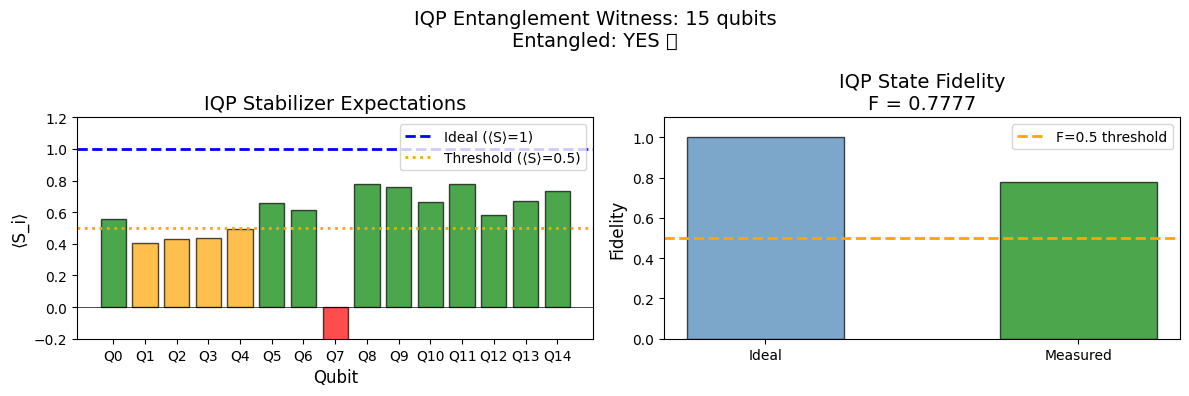

In [37]:
# CELL 16: Visualization

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Stabilizer values
ax = axes[0]
qubits = list(range(N_QUBITS))
stab_vals = result['stabilizer_values']
colors = ['green' if s > 0.5 else 'orange' if s > 0 else 'red' for s in stab_vals]

bars = ax.bar(qubits, stab_vals, color=colors, alpha=0.7, edgecolor='black')
ax.axhline(1.0, color='blue', linestyle='--', linewidth=2, label='Ideal (⟨S⟩=1)')
ax.axhline(0.5, color='orange', linestyle=':', linewidth=2, label='Threshold (⟨S⟩=0.5)')
ax.axhline(0.0, color='black', linewidth=0.5)

ax.set_xlabel('Qubit', fontsize=12)
ax.set_ylabel('⟨S_i⟩', fontsize=12)
ax.set_title('IQP Stabilizer Expectations', fontsize=14)
ax.set_xticks(qubits)
ax.set_xticklabels([f'Q{i}' for i in qubits])
ax.legend()
ax.set_ylim(-0.2, 1.2)

# Plot 2: Fidelity comparison
ax = axes[1]
categories = ['Ideal', 'Measured']
values = [1.0, result['fidelity']]
colors = ['steelblue', 'green' if result['fidelity'] > 0.5 else 'red']

ax.bar(categories, values, color=colors, alpha=0.7, edgecolor='black', width=0.5)
ax.axhline(0.5, color='orange', linestyle='--', linewidth=2, label='F=0.5 threshold')
ax.set_ylabel('Fidelity', fontsize=12)
ax.set_title(f'IQP State Fidelity\nF = {result["fidelity"]:.4f}', fontsize=14)
ax.set_ylim(0, 1.1)
ax.legend()

plt.suptitle(f'IQP Entanglement Witness: {N_QUBITS} qubits\n'
             f'Entangled: {"YES ✅" if result["is_entangled"] else "NO ❌"}', fontsize=14)
plt.tight_layout()
plt.show()